In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import SVHN
from fedlab.utils.dataset.partition import SVHNPartitioner

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f'{device} is available')

mps is available


In [3]:
# Define transformations for SVHN dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [4]:
# Load SVHN dataset
dataset_path = "path_to_data"
trainset = SVHN(root=dataset_path, split="train", download=True, transform=transform)
testset = SVHN(root=dataset_path, split="test", download=True, transform=transform)

Using downloaded and verified file: path_to_data/train_32x32.mat
Using downloaded and verified file: path_to_data/test_32x32.mat


In [5]:
def partition_data(dataset, num_clients, alpha):
    """
    Partitions the dataset using Dirichlet distribution to simulate heterogeneity.
    """
    targets = np.array(dataset.labels)
    num_classes = len(np.unique(targets))
    client_indices = {i: [] for i in range(num_clients)}

    # Dirichlet distribution for each class
    class_indices = [np.where(targets == i)[0] for i in range(num_classes)]
    for c, indices in enumerate(class_indices):
        np.random.shuffle(indices)
        proportions = np.random.dirichlet([alpha] * num_clients)
        proportions = (np.cumsum(proportions) * len(indices)).astype(int)[:-1]
        split_indices = np.split(indices, proportions)
        for i, split in enumerate(split_indices):
            client_indices[i].extend(split)

    return client_indices

In [6]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 16 * 16, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def train_on_worker(model, dataloader, device="cpu"):
    """
    Trains a model on a worker's local data.
    """
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    model.train()
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Return model parameters as updates
    return {k: v.clone() for k, v in model.state_dict().items()}

In [8]:
def aggregate_updates(updates):
    """
    Averages updates for global aggregation.
    """
    return {k: torch.mean(torch.stack([u[k] for u in updates]), dim=0) for k in updates[0]}

def full_trim(update, fraction):
    """
    Applies a full-trim attack to a model update.
    """
    for key, param in update.items():
        k = int(param.numel() * fraction)
        flat = param.view(-1)
        flat[torch.topk(flat.abs(), k=k, largest=False).indices] = 0
        param.copy_(flat.view_as(param))
    return update

In [9]:
def evaluate_model(model, dataloader, device="cpu"):
    """
    Evaluates the model on the test set.
    """
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

In [10]:
alphas = [0.1, 0.3, 1.0, 5.0, 10.0]
num_clients = 100
attack_fraction = 0.4
results = []
Epochs = 15

for alpha in alphas:
    print(f"Running simulations for alpha = {alpha}...")
    client_indices = partition_data(trainset, num_clients, alpha)
    workers = {
        i: DataLoader(Subset(trainset, indices), batch_size=32, shuffle=True)
        for i, indices in client_indices.items()
    }
    test_loader = DataLoader(testset, batch_size=32, shuffle=False)

    normal_accuracies = []
    attack_accuracies = []

    for attack in [False, True]:
        mode = "Attack" if attack else "No Attack"
        print(f"  Running mode: {mode}")
        model = SimpleCNN()
        for _ in range(Epochs):
            updates = []
            for i, loader in workers.items():
                local_update = train_on_worker(model, loader, device)
                if attack and random.random() < attack_fraction:
                    local_update = full_trim(local_update, 0.6)
                updates.append(local_update)

            aggregated_update = aggregate_updates(updates)
            model.load_state_dict(aggregated_update)

        acc = evaluate_model(model, test_loader, device)
        print(f"    Accuracy: {acc:.4f}")
        if attack:
            attack_accuracies.append(acc)
        else:
            normal_accuracies.append(acc)

    alpha_value = alpha if isinstance(alpha, float) else alpha.split('_')[2]
    results.append({
        "Alpha": alpha_value,
        "Normal Accuracy": np.mean(normal_accuracies),
        "Attack Accuracy": np.mean(attack_accuracies),
    })

Running simulations for alpha = 0.1...
  Running mode: No Attack
    Accuracy: 70.5439
  Running mode: Attack
    Accuracy: 18.8307
Running simulations for alpha = 0.3...
  Running mode: No Attack
    Accuracy: 76.8362
  Running mode: Attack
    Accuracy: 72.8757
Running simulations for alpha = 1.0...
  Running mode: No Attack
    Accuracy: 78.6494
  Running mode: Attack
    Accuracy: 77.2626
Running simulations for alpha = 5.0...
  Running mode: No Attack
    Accuracy: 78.6109
  Running mode: Attack
    Accuracy: 77.8542
Running simulations for alpha = 10.0...
  Running mode: No Attack
    Accuracy: 79.8171
  Running mode: Attack
    Accuracy: 77.9809


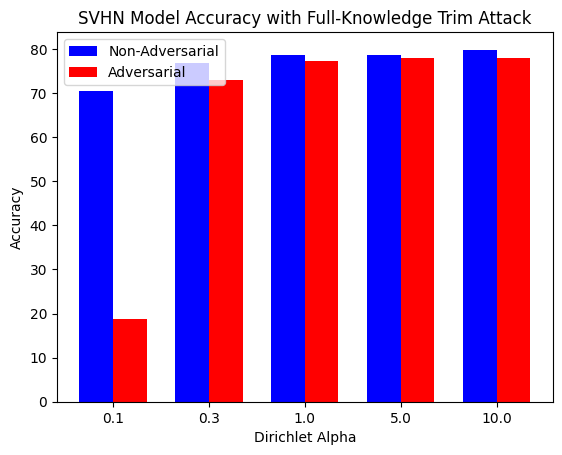

In [11]:
results_df = pd.DataFrame(results)

# Create a bar width and positions
bar_width = 0.35
alphas = results_df["Alpha"].astype(str)
positions = np.arange(len(alphas))

# Plot the bar graph
plt.bar(positions - bar_width / 2, results_df["Normal Accuracy"], bar_width, label="Non-Adversarial", color='b')
plt.bar(positions + bar_width / 2, results_df["Attack Accuracy"], bar_width, label="Adversarial", color='r')

# Add labels and titles
plt.xlabel("Dirichlet Alpha")
plt.ylabel("Accuracy")
plt.title("SVHN Model Accuracy with Full-Knowledge Trim Attack")
plt.xticks(positions, alphas)
plt.legend()

# Save and show the plot
plt.savefig("SVHN_FKTA_Results.png")
plt.show()